<a href="https://colab.research.google.com/github/anas-awadalla/Incepto/blob/master/OOD_Normalized_Score_for_Mahalanobis_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Create LR Detector

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split
def stratified_split(X, y, test_size=0.5):
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=test_size)

    return X_train, y_train, X_test, y_test

In [5]:
def load_characteristics(filename):
    """
    Load the calculated scores
    return: data and label of input score
    """
    X, Y = None, None
    
    data = np.load(filename)
    
    if X is None:
        X = data[:, :-1]
    else:
        X = np.concatenate((X, data[:, :-1]), axis=1)
    if Y is None:
        Y = data[:, -1] # labels only need to load once
         
    return X, Y

Apply Demensionality Reduction

In [6]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import MDS

total_X, total_Y = load_characteristics("ood.npy")
X_val, Y_val, X_test, Y_test = stratified_split(total_X, total_Y)
                
X_train, Y_train, X_val_for_test, Y_val_for_test = stratified_split(X_val, Y_val, test_size=0.5)
lr = LogisticRegressionCV(n_jobs=-1, max_iter=1000).fit(X_train, Y_train)
                
y_pred = lr.predict_proba(X_train)[:, 1]
                
X_embedded = PCA(n_components=2).fit_transform(total_X)


In [7]:
total_y_predicted = lr.predict(total_X)
total_y_confidence = lr.predict_proba(total_X)

Visualize Data Points

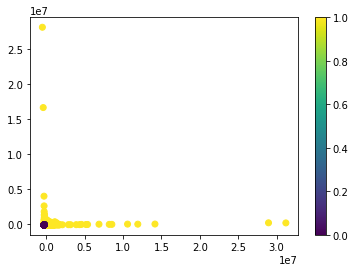

In [8]:
plt.scatter(X_embedded[:,0],X_embedded[:,1] , c=total_y_predicted)
plt.colorbar()
plt.draw()

Split Dataset

In [9]:
X_in_dist = []
X_ood = []

for i,j in zip(X_embedded, total_y_predicted):
  if j == 0:
    X_in_dist.append(i)
  else :
    X_ood.append(i)

X_in_dist = np.array(X_in_dist)
X_ood = np.array(X_ood)

Find Largest Distance In Distribution

In [40]:
from itertools import combinations
from random import randint

def square_distance(x,y): return sum([(xi-yi)**2 for xi, yi in zip(x,y)])    

max_square_distance = 0
for pair in combinations(X_in_dist,2):
    if square_distance(*pair) > max_square_distance:
        max_square_distance = square_distance(*pair)
        max_pair = pair

circle_x = (max_pair[0][0]+max_pair[1][0])/2
circle_y = (max_pair[0][1]+max_pair[1][1])/2
circle_radius = math.sqrt(max_square_distance)/2

In Distribution Radius Visualization

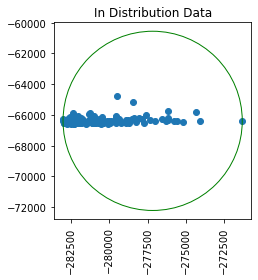

In [51]:
import math  

fig, ax = plt.subplots()

circle = plt.Circle((circle_x, circle_y), circle_radius, color='g', fill=False)
ax.scatter(X_in_dist[:,0],X_in_dist[:,1])
ax.set_aspect('equal', adjustable='box')
ax.add_patch(circle)
plt.title("In Distribution Data")
plt.xticks(rotation=90)
plt.tight_layout()
plt.draw()

Get an Interpretable OOD Score

---
d1 = Distance to In_Distribution Circle

range = (threshold - 1) * radius

score = d1/range ( IF SCORE < 0: SCORE = 0 // IF SCORE > 1: SCORE = 1)


final_score = 1- score


In [55]:
import math

def get_distance_to_circle(circle_x, circle_y, radius, x, y):
  return math.sqrt(square_distance((circle_x,circle_y),(x,y))) - radius

In [111]:
def get_ood_score(circle_x, circle_y, radius, threshold, ood_x, ood_y):
  dist = get_distance_to_circle(circle_x,circle_y,radius,ood_x,ood_y)
  if dist < 0: return 0.0
  
  ood_threshold_dist = radius * (threshold-1)

  if dist > ood_threshold_dist: return 1.0

  normalized_dist = ((ood_threshold_dist - dist)/ood_threshold_dist)

  return 1 - normalized_dist

In Distribution Score Distribution Histogram



(array([149.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

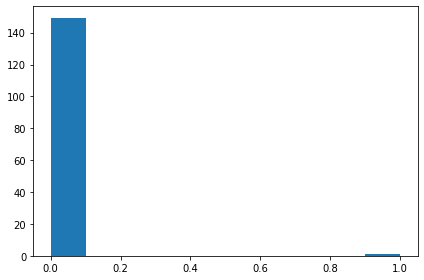

In [119]:
radius_threshold = 1.0  #@param {type: "slider", min: 1.0, max: 100, step: 0.1}
in_dist_scores = []

for point in X_in_dist:
  score = get_ood_score(circle_x, circle_y, circle_radius, radius_threshold, point[0], point[1])
  in_dist_scores.append(score)

n_bins = 10
fig, ax = plt.subplots(1, 1, sharey=True, tight_layout=True)
ax.hist(in_dist_scores, bins=n_bins)


Out of Distribution Score Distribution Histogram

(array([263., 216., 108.,  67.,  44.,  29.,  20.,  15.,  13., 455.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

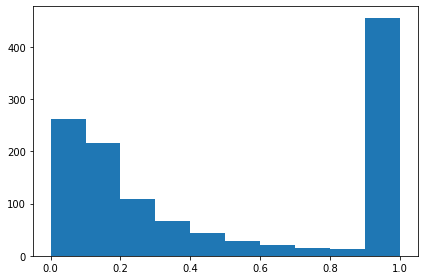

In [118]:
radius_threshold = 24.2  #@param {type: "slider", min: 1.0, max: 100, step: 0.1}
in_dist_scores = []

for point in X_ood:
  score = get_ood_score(circle_x, circle_y, circle_radius, radius_threshold, point[0], point[1])
  in_dist_scores.append(score)

n_bins = 10
fig, ax = plt.subplots(1, 1, sharey=True, tight_layout=True)
ax.hist(in_dist_scores, bins=n_bins)

Putting Everything Together


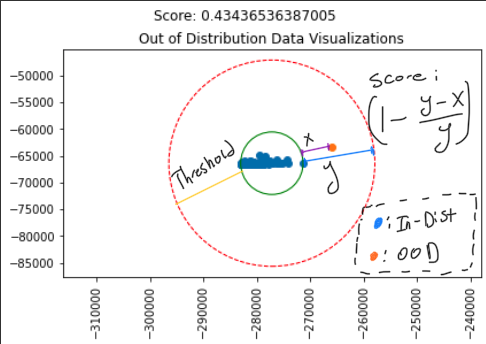

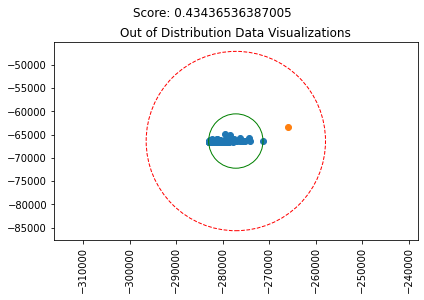

In [133]:
import math  
index = 0  #@param {type: "slider", min: 0, max: 1226}
radius_threshold = 3.3  #@param {type: "slider", min: 1.0, max: 10, step: 0.1}

fig, ax = plt.subplots()

circle = plt.Circle((circle_x, circle_y), circle_radius, color='g', fill=False)
threshold_circle = plt.Circle((circle_x, circle_y), circle_radius*radius_threshold, color='r', linestyle='--', fill=False)

ax.add_patch(circle)
ax.add_patch(threshold_circle)


ax.scatter(X_in_dist[:,0],X_in_dist[:,1])

ax.scatter(X_ood[index,0], X_ood[index,1])

ax.set_aspect('equal', adjustable='datalim')

score = get_ood_score(circle_x, circle_y, circle_radius, radius_threshold, X_ood[index,0], X_ood[index,1])
plt.title("Out of Distribution Data Visualizations")
plt.suptitle("Score: "+str(score), y=1.03)

plt.xticks(rotation=90)
plt.tight_layout()
plt.draw()